In [1]:
import pandas as pd
from collections import Counter, defaultdict
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import umap
%matplotlib inline
datafile = 'dataset2.count.txt'
df = pd.read_csv(datafile, sep='\t')

In [2]:
df = df.set_index('Gene.Symbol')
cells = list(df.columns.values)

In [3]:
mat = np.array(df)
per_cell_sum = mat.sum(axis=1)
per_gene_sum = mat.sum(axis=0)
low_expr_thr = 100
high_expr_thr = 1000000
mat = mat[:, (per_gene_sum>=low_expr_thr) & (per_gene_sum<=high_expr_thr)]
mean_exp = mat.mean(axis=0)
std_exp = np.sqrt(mat.std(axis=0))
CV = std_exp/mean_exp
mat = mat[:, CV >= 1.5]
cells_expression = mat.sum(axis=1)
mat = mat[cells_expression>=100, :]
mat = np.log(mat+1)
#df = pd.DataFrame(mat,index=mat[:,0])

In [ ]:
def dendrogrammer(df, leaf_labels):
    D = df.values
    if len(leaf_labels) != len(D):
        D = np.transpose(D)
    Z = linkage(D, method='ward', metric='euclidean')
    plt.figure(figsize=(10, 10))
    ax = plt.subplot()
    plt.subplots_adjust(left=0.07, bottom = 0.3, right = 0.98, top = 0.95, wspace=0, hspace=0)
    plt.xlabel('Cell Line')
    plt.ylabel('Distance')
    
    dendrogram(Z, leaf_rotation=90., leaf_font_size=10., labels = leaf_labels)
    plt.savefig('dendrogram_nci60.png')

In [ ]:

dendrogrammer(df, cells)

In [4]:
def PCAer(df):
     print(df.values)
     D = df.values
     D = np.transpose(D)
     pca = PCA(n_components= 50)
     pca.fit(D)
     projected = pca.fit_transform(D)
     return projected

In [5]:
from sklearn.cluster import KMeans
Dpc = PCAer(df)
kmeans = KMeans(n_clusters=3)
kmeans = kmeans.fit(Dpc)
print(Dpc)
print(kmeans)
labels = kmeans.predict(Dpc)
C = kmeans.cluster_centers_
out = [Dpc, labels, C]
[proj, labels, centroids] = out
true_coords = {}
true_cells = {}
true_labels = {}
for i in range(len(Dpc)):
    coords = str(proj[i:i+1,0]) + " " + str(proj[i+1:i+2,1]) + " " + str(proj[ i+2:i+3,2])
    print(coords)
    true_cells.update({str(coords).strip():labels[i]})
    true_labels.update({cells[i]:labels[i]})
    true_coords.update({cells[i]:str(coords).strip()})
print(true_coords)
print(true_cells)
'''
def kmeanser(df, k): 
    Dpc = PCAer(df)
    kmeans = KMeans(n_clusters=3)
    kmeans = kmeans.fit(Dpc)
    labels = kmeans.predict(Dpc)
    C = kmeans.cluster_centers_
    out = [Dpc, labels, C]
    print(np.bincount(kmeans.labels_))
    return out
'''
def ClusterIndicesNumpy(clustNum, labels_array): #numpy 
    return np.where(labels_array == clustNum)[0]

def ClusterIndicesComp(clustNum, labels_array): #list comprehension
    return np.array([i for i, x in enumerate(labels_array) if x == clustNum])

[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [159 215 200 ... 176 185   0]
 [  0   3   2 ...   2   2   0]
 [377 722 855 ... 525 151   1]]
[[ -703.68924358 -1010.61014148   130.83626952 ...   -20.43972356
    -18.12505957   -73.44028002]
 [  398.47282274   862.35697391  -458.7283149  ...   -26.86646575
    -58.23798847   -35.86870313]
 [ 1485.37917175   503.05158759  -881.79335916 ...   -54.22691162
     39.63416509   -77.93120441]
 ...
 [  429.27632876  -315.70123919  -459.01866926 ...   -27.06404304
     -9.23510397   -19.45568377]
 [-1690.38196269  -697.25991904   -84.3303534  ...   -17.6684787
     -6.86660023    18.09171117]
 [-2851.13231245  -950.39069922   227.29107016 ...   -43.71524968
    -33.23872448   -15.43091589]]
KMeans(n_clusters=3)
[-703.68924358] [862.35697391] [-881.79335916]
[398.47282274] [503.05158759] [-1082.00211885]
[1485.37917175] [246.99246747] [-674.68192667]
[3129.24933374] [-219.83983542] [-351.37245189]

[11221.8012744] [1065.2137833] [-364.1270796]
[-453.816904] [204.83315051] [-1348.20267465]
[-1732.65946329] [-297.90750954] [-1077.98869874]
[3352.74335542] [1250.45993292] [-1253.96390824]
[-348.80002516] [657.04935564] [-690.86737053]
[1443.15077982] [-2208.67850794] [-122.34250759]
[4959.40015301] [-283.54402016] [-294.524784]
[-1344.32019968] [337.73535488] [-1413.10590731]
[-562.2920057] [1094.48212647] [1073.9968255]
[2420.29055578] [-652.76848264] [-481.83520781]
[-1696.40586553] [-512.79242798] [224.66712698]
[214.77571371] [-65.51381593] [190.57436489]
[735.76600068] [-741.66136656] [3285.37238781]
[-1669.14658902] [3161.94709136] [-238.11738747]
[5648.28569852] [118.71259713] [241.04810863]
[-1632.92774503] [-656.44972924] [-214.02480288]
[-2123.72423866] [2354.73949733] [-83.85720175]
[660.56611935] [-92.71028432] [-280.77557595]
[-1995.10465076] [-32.93202286] [-146.52154498]
[-2395.05430839] [-77.78047636] [-161.75634603]
[-2280.22438969] [1472.64758854] [-1667.01807138]


[-1007.91937708] [243.61075364] [-563.73963309]
[-1598.55674158] [-467.41894587] [-477.68162174]
[-1296.81836577] [-974.28660068] [199.14499948]
[-488.80039838] [-1110.44606425] [-281.01859763]
[-276.57626518] [-132.26594407] [719.19796057]
[-1439.52427279] [578.01693319] [-55.05755447]
[-1739.23182772] [-163.09951699] [-53.15674006]
[-1455.65069528] [-1593.54818068] [-813.28496614]
[873.17197237] [-1407.09281928] [-311.10116822]
[-537.70449353] [-1152.41130554] [-333.58304013]
[135.13227611] [-324.16860108] [-66.66117024]
[-1080.04361764] [-699.93110579] [-330.6728147]
[1313.33243938] [1080.2694372] [590.77585661]
[-1573.54013633] [408.61707659] [-640.27916731]
[-450.47807448] [323.47801399] [-281.04949649]
[-359.23124315] [322.9725262] [-563.00618903]
[1199.98697713] [701.7844922] [-218.86207717]
[-1206.2448315] [-154.01860233] [-496.04589324]
[-1889.24484849] [-620.61046519] [405.15461522]
[-82.77188992] [-76.98530198] [-174.93755198]
[-2442.54418158] [-712.74564157] [-226.17136273]

In [8]:
import json
def DataCollection(algorithm, cluster_1, cluster_2, cluster_3, results):
    
    labels = true_labels
    
    num1 = []
    num2 = []
    num3 = []
    
#     num1 = ClusterIndicesNumpy(0, algorithm.labels_)
#     num2 = ClusterIndicesNumpy(1, algorithm.labels_)
#     num3 = ClusterIndicesNumpy(2, algorithm.labels_) 
    barcodes1 = {}
    barcodes2 = {}
    barcodes3 = {}
    truthnum1 = {}
    for i in labels:
        if labels[i] == 0:
            barcodes1.update({i:labels[i]})
        elif labels[i] == 1:
            barcodes2.update({i:labels[i]})
        else:
            barcodes3.update({i:labels[i]})
        
#     for i in num1:
#         barcodes1.update({cells[i]:i})
#     for i in num2:
#         barcodes2.update({cells[i]:i})
#     for i in num3:
#         barcodes3.update({cells[i]:i})
    with open(cluster_1, 'w') as filehandle:
        for listitem in barcodes1:
            filehandle.write('%s\n' % listitem)
    with open(cluster_2, 'w') as filehandle:
        for listitem in barcodes2:
            filehandle.write('%s\n' % listitem)
    with open(cluster_3, 'w') as filehandle:
        for listitem in barcodes3:
            filehandle.write('%s\n' % listitem)
        
        
    g1 = open('G1Cells.txt').readlines()
    g1_line = []
    for lines in g1:
        g1_line.append(lines)
    g2m = open('G2MCells.txt').readlines()
    g2m_line = []
    for lines in g2m:
        g2m_line.append(lines)
    s = open('SCells.txt').readlines()
    s_line = []

    res = open(results, "w")

    g1count = 0
    g2mcount = 0
    scount = 0

    g1count2 = 0
    g2mcount2 = 0
    scount2 = 0

    g1count3 = 0
    g2mcount3 = 0
    scount3 = 0
    
    x = 0
    y = 0
    z = 0

#     for lines in s:
#         s_line.append(lines)
#     cluster1 = open(cluster_1).readlines()
#     cluster1_line = []
#     for lines in cluster1:
#         cluster1_line.append(lines)
#     for i in cluster1_line:
#         for j in g1_line:
#             if i == j:
#                 g1count = g1count + 1
#                 truthnum1.update({true_coords[i[0:len(i)-1]]:'#6E316F'})
#                 #DataCollection.truthnum1.update({(barcodes1[i]):'black'})
#     res.write("G1 Count Cluster 1: \n")
#     res.write(str(g1count/(len(cluster1_line))) + " \n")
#     res.write(str(g1count) + " \n")
#     for x in cluster1_line:
#         for y in g2m_line:
#             if x == y:
#                 g2mcount = g2mcount + 1
#                 truthnum1.update({true_coords[x[0:len(x)-1]]:'#FCC7FD'})
#                 #DataCollection.truthnum1.update({(barcodes1[i]):'red'})
#     res.write("G2M Count Cluster 1: \n")
#     res.write(str(g2mcount/(len(cluster1_line))) + "\n")
#     res.write(str(g2mcount) + "\n")
#     for i in cluster1_line:
#         for j in s_line:
#             if i == j:
#                 scount = scount + 1
#                 truthnum1.update({true_coords[i[0:len(i)-1]]:'#F204F9'})
#                 #DataCollection.truthnum1.update({(barcodes1[i]):'red'})
#     res.write("S Count Cluster 1: \n")
#     res.write(str(scount/(len(cluster1_line))) + "\n")
#     res.write(str(scount) + "\n")
#     res.write("\n")

#     cluster2 = open(cluster_2).readlines()
#     cluster2_line = []
#     for lines in cluster2:
#         cluster2_line.append(lines)
#     for i in cluster2_line:
#         for j in g1_line:
#             if i == j:
#                 g1count2 = g1count2 + 1
#                 truthnum1.update({true_coords[i[0:len(i)-1]]:'#003674'})
#                 #DataCollection.truthnum1.update({(barcodes2[i]):'red'})
#     res.write("G1 Count Cluster 2:" + "\n")
#     res.write(str(g1count2/(len(cluster2_line))) + "\n")
#     res.write(str(g1count2) + "\n")
#     for i in cluster2_line:
#         for j in g2m_line:
#             if i == j:
#                 g2mcount2 = g2mcount2 + 1
#                 truthnum1.update({true_coords[i[0:len(i)-1]]:'#EBF3FA'})
#                 #DataCollection.truthnum1.update({(barcodes2[i]):'black'})
#     res.write("G2M Count Cluster 2:" + "\n")
#     res.write(str(g2mcount2/(len(cluster2_line))) + "\n")
#     res.write(str(g2mcount2) + "\n")
#     for i in cluster2_line:
#         for j in s_line:
#             if i == j:
#                 scount2 = scount2 + 1
#                 truthnum1.update({true_coords[i[0:len(i)-1]]:'#4BABFF'})
#                 #DataCollection.truthnum1.update({(barcodes2[i]):'red'})
#     res.write("S Count Cluster 2: \n")
#     res.write(str(scount2/(len(cluster2_line))) + "\n")
#     res.write(str(scount2) + "\n")
#     res.write("\n")

#     cluster3 = open(cluster_3).readlines()
#     cluster3_line = []
#     for lines in cluster3:
#         cluster3_line.append(lines)
#     for i in cluster3_line:
#         for j in g1_line:
#             if i == j:
#                 g1count3 = g1count3 + 1
#                 truthnum1.update({true_coords[i[0:len(i)-1]]:'#006506'})
#                 #DataCollection.truthnum1.update({(barcodes3[i]):'red'})
#     res.write("G1 Count Cluster 3:" + "\n")
#     res.write(str(g1count3/(len(cluster3_line))) + "\n")
#     res.write(str(g1count3) + "\n")
#     for i in cluster3_line:
#         for j in g2m_line:
#             if i == j:
#                 g2mcount3 = g2mcount3 + 1
#                 truthnum1.update({true_coords[i[0:len(i)-1]]:'#E6F9E5'})
#                 #DataCollection.truthnum1.update({(barcodes3[i]):'red'})
#     res.write("G2M Count Cluster 3:" + "\n")
#     res.write(str(g2mcount3/(len(cluster3_line))) + "\n")
#     res.write(str(g2mcount3) + "\n")
#     for i in cluster3_line:
#         for j in s_line:
#             if i == j:
#                 scount3 = scount3 + 1
#                 truthnum1.update({true_coords[i[0:len(i)-1]]:'#00FF0F'})
#                 #DataCollection.truthnum1.update({(barcodes3[i]):'black'})
#     res.write("S Count Cluster 3:" + "\n")
#     res.write(str(scount3/(len(cluster3_line))) + "\n")
#     res.write(str(scount3) + "\n")
#     res.write("\n")
#     res.write(json.dumps(truthnum1))
#     res.write("")
    for lines in s:
        s_line.append(lines)
    cluster1 = open(cluster_1).readlines()
    cluster1_line = []
    for lines in cluster1:
        cluster1_line.append(lines)
    for i in cluster1_line:
        for j in g1_line:
            if i == j:
                g1count = g1count + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'black'})
                #DataCollection.truthnum1.update({(barcodes1[i]):'black'})
    res.write("G1 Count Cluster 1: \n")
    res.write(str(g1count/(len(cluster1_line))) + " \n")
    res.write(str(g1count) + " \n")
    for x in cluster1_line:
        for y in g2m_line:
            if x == y:
                g2mcount = g2mcount + 1
                truthnum1.update({true_coords[x[0:len(x)-1]]:'red'})
                #DataCollection.truthnum1.update({(barcodes1[i]):'red'})
    res.write("G2M Count Cluster 1: \n")
    res.write(str(g2mcount/(len(cluster1_line))) + "\n")
    res.write(str(g2mcount) + "\n")
    for i in cluster1_line:
        for j in s_line:
            if i == j:
                scount = scount + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'red'})
                #DataCollection.truthnum1.update({(barcodes1[i]):'red'})
    res.write("S Count Cluster 1: \n")
    res.write(str(scount/(len(cluster1_line))) + "\n")
    res.write(str(scount) + "\n")
    res.write("\n")

    cluster2 = open(cluster_2).readlines()
    cluster2_line = []
    for lines in cluster2:
        cluster2_line.append(lines)
    for i in cluster2_line:
        for j in g1_line:
            if i == j:
                g1count2 = g1count2 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'red'})
                #DataCollection.truthnum1.update({(barcodes2[i]):'red'})
    res.write("G1 Count Cluster 2:" + "\n")
    res.write(str(g1count2/(len(cluster2_line))) + "\n")
    res.write(str(g1count2) + "\n")
    for i in cluster2_line:
        for j in g2m_line:
            if i == j:
                g2mcount2 = g2mcount2 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'black'})
                #DataCollection.truthnum1.update({(barcodes2[i]):'black'})
    res.write("G2M Count Cluster 2:" + "\n")
    res.write(str(g2mcount2/(len(cluster2_line))) + "\n")
    res.write(str(g2mcount2) + "\n")
    for i in cluster2_line:
        for j in s_line:
            if i == j:
                scount2 = scount2 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'red'})
                #DataCollection.truthnum1.update({(barcodes2[i]):'red'})
    res.write("S Count Cluster 2: \n")
    res.write(str(scount2/(len(cluster2_line))) + "\n")
    res.write(str(scount2) + "\n")
    res.write("\n")

    cluster3 = open(cluster_3).readlines()
    cluster3_line = []
    for lines in cluster3:
        cluster3_line.append(lines)
    for i in cluster3_line:
        for j in g1_line:
            if i == j:
                g1count3 = g1count3 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'red'})
                #DataCollection.truthnum1.update({(barcodes3[i]):'red'})
    res.write("G1 Count Cluster 3:" + "\n")
    res.write(str(g1count3/(len(cluster3_line))) + "\n")
    res.write(str(g1count3) + "\n")
    for i in cluster3_line:
        for j in g2m_line:
            if i == j:
                g2mcount3 = g2mcount3 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'red'})
                #DataCollection.truthnum1.update({(barcodes3[i]):'red'})
    res.write("G2M Count Cluster 3:" + "\n")
    res.write(str(g2mcount3/(len(cluster3_line))) + "\n")
    res.write(str(g2mcount3) + "\n")
    for i in cluster3_line:
        for j in s_line:
            if i == j:
                scount3 = scount3 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'black'})
                #DataCollection.truthnum1.update({(barcodes3[i]):'black'})
    res.write("S Count Cluster 3:" + "\n")
    res.write(str(scount3/(len(cluster3_line))) + "\n")
    res.write(str(scount3) + "\n")
    res.write("\n")
    res.write(json.dumps(truthnum1))
    res.write("")
    print(len(truthnum1))
    return truthnum1


626


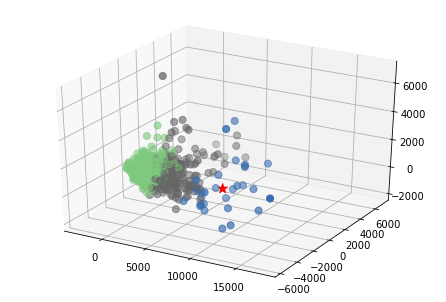

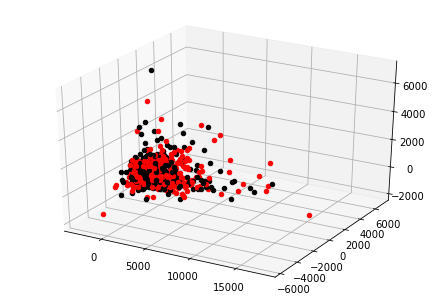

In [9]:
from mpl_toolkits.mplot3d import Axes3D
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1 = Axes3D(fig1)
[proj, labels, centroids] = out
ax1.scatter(proj[:,0], proj[:, 1], proj[:, 2], c=labels, s=50, cmap='Accent')

colors = DataCollection(kmeans, 'kmeans_cluster1.txt', 'kmeans_cluster2.txt', 'kmeans_cluster3.txt', 'kmeans_results.txt')
ax1.scatter(centroids[:,0], centroids[:, 1], centroids[:,2], c = 'red', s=100, marker='*', cmap='Accent')
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2 = Axes3D(fig2)
for i in range(len(proj)):
    coords = str(proj[i:i+1,0]) + " " + str(proj[i+1:i+2,1]) + " " + str(proj[ i+2:i+3,2])
    ax2.scatter(proj[i:i+1, 0], proj[i+1:i+2, 1], proj[i+2:i+3, 2], c=colors[coords])


In [ ]:
plt.scatter(proj[:,0], proj[:,2], s=10.0, color='black')
plt.scatter(centroids[:,0], centroids[:, 2], c = 'red', s = 100, marker='*', cmap='Accent')

In [ ]:
from sklearn.metrics import silhouette_score
K = range(2, 10)
sil = []
Dpc = PCAer(df)
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans = kmeans.fit(Dpc)
    labels = kmeans.predict(Dpc)
    sil.append(silhouette_score(Dpc, labels))
plt.plot(K, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette')
plt.title('The Silhouette showing the optimal k')
plt.show()

In [ ]:
from scipy.spatial.distance import cdist
distortions = []
K = range(1, 10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(df)
    kmeanModel.fit(df)
    #distortions.append(sum(np.min(cdist(df, kmeanModel.cluster_centers_, 'euclidean'), axis = 1))/df.shape[0])
    distortions.append(kmeanModel.inertia_)
print(distortions)

In [ ]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()